In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import logging

from asgardpy.analysis import AsgardpyAnalysis
from asgardpy.config import AsgardpyConfig

from gammapy.modeling.models import Models, PowerLawSpectralModel

In [2]:
from asgardpy.base.geom import create_counts_map, generate_geom, get_source_position
from asgardpy.base.reduction import (
    generate_dl4_dataset,
    get_bkg_maker,
    get_dataset_maker,
    get_dataset_reference,
    get_exclusion_region_mask,
    get_filtered_observations,
    get_safe_mask_maker,
)
from asgardpy.data.dataset_3d import Dataset3DGeneration
from asgardpy.data.target import apply_selection_mask_to_models

In [3]:
# os.environ['GAMMAPY_DATA']

In [4]:
log = logging.getLogger("test 3d dataset")

In [5]:
config_file = "../src/asgardpy/tests/config_test_base.yaml"

In [6]:
config = AsgardpyConfig()

In [7]:
%%time
config_main = config.read(config_file)

CPU times: user 44.8 ms, sys: 2.17 ms, total: 46.9 ms
Wall time: 45.6 ms


# Update path of test data

In [8]:
config_main.dataset3d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset3d.instruments[0].input_dl3[1].input_dir = f"{os.environ['GAMMAPY_DATA']}fermipy-crab/"
config_main.dataset1d.instruments[0].input_dl3[0].input_dir = f"{os.environ['GAMMAPY_DATA']}hess-dl3-dr1/"

In [9]:
config_main.general.dict()

{'log': {'level': 'info',
  'filename': '',
  'filemode': 'w',
  'format': '',
  'datefmt': ''},
 'outdir': PosixPath('.'),
 'n_jobs': 10,
 'parallel_backend': <ParallelBackendEnum.multi: 'multiprocessing'>,
 'steps': [<AnalysisStepEnum.datasets_3d: 'datasets-3d'>,
  <AnalysisStepEnum.datasets_1d: 'datasets-1d'>,
  <AnalysisStepEnum.fit: 'fit'>,
  <AnalysisStepEnum.flux_points: 'flux-points'>],
 'overwrite': True,
 'stacked_dataset': True}

# Steps mentioned in the main config file

In [10]:
config_main.general.steps

[<AnalysisStepEnum.datasets_3d: 'datasets-3d'>,
 <AnalysisStepEnum.datasets_1d: 'datasets-1d'>,
 <AnalysisStepEnum.fit: 'fit'>,
 <AnalysisStepEnum.flux_points: 'flux-points'>]

# Target source information

In [11]:
config_main.target.dict()

{'source_name': '4FGL J0534.5+2201i',
 'sky_position': {'frame': <FrameEnum.icrs: 'icrs'>,
  'lon': <Angle 83.6338333 deg>,
  'lat': <Angle 22.0145 deg>,
  'radius': <Angle 0. deg>},
 'use_uniform_position': True,
 'models_file': PosixPath('.'),
 'datasets_with_fov_bkg_model': [],
 'use_catalog': {'name': '',
  'selection_radius': <Angle 0. deg>,
  'exclusion_radius': <Angle 0. deg>},
 'components': [{'name': '4FGL J0534.5+2201i',
   'type': <ModelTypeEnum.skymodel: 'SkyModel'>,
   'datasets_names': [''],
   'spectral': {'type': 'LogParabolaSpectralModel',
    'parameters': [{'name': 'amplitude',
      'value': 1e-06,
      'unit': 'cm-2 s-1 TeV-1',
      'error': 1.5e-07,
      'min': 1e-13,
      'max': 0.01,
      'frozen': False},
     {'name': 'reference',
      'value': 0.015,
      'unit': 'TeV',
      'error': 0.0,
      'min': 0.0001,
      'max': 100.0,
      'frozen': True},
     {'name': 'alpha',
      'value': 1.7,
      'unit': '',
      'error': 0.1,
      'min': 0.5,
  

# 3D Datasets informations

In [12]:
config_main.dataset3d.dict()

{'type': <ReductionTypeEnum.cube: '3d'>,
 'instruments': [{'name': 'Fermi-LAT',
   'input_dl3': [{'type': 'lat',
     'input_dir': PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab'),
     'glob_pattern': {'events': '*ft*.fits*',
      'edisp': 'drm*.fits*',
      'xml_model': 'srcmdl*.xml',
      'exposure': 'bexpmap*.fits*',
      'psf': 'psf*.fits*'}},
    {'type': 'lat-aux',
     'input_dir': PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab'),
     'glob_pattern': {'gal_diffuse': 'gll_iem_v07_cutout.fits*',
      'iso_diffuse': 'iso_P8R3_SOURCE_V3_*.txt'}}],
   'input_dl4': False,
   'dataset_info': {'name': 'Fermi-LAT',
    'key': ['00', '01'],
    'observation': {'obs_ids': [],
     'obs_file': PosixPath('.'),
     'obs_time': [],
     'obs_cone': {'frame': <FrameEnum.icrs: 'icrs'>,
      'lon': <Angle 0. deg>,
      'lat': <Angle 0. deg>,
      'radius': <Angle 0. deg>},
    

In [13]:
config_main.fit_params.dict()

{'fit_range': {'min': <Quantity 1. GeV>, 'max': <Quantity 40. TeV>},
 'backend': <BackendEnum.minuit: 'minuit'>,
 'optimize_opts': {},
 'covariance_opts': {},
 'confidence_opts': {},
 'store_trace': True}

In [14]:
%%time
analysis = AsgardpyAnalysis(config_main)

Setting logging config: {'level': 'INFO', 'filename': '', 'filemode': 'w', 'format': '', 'datefmt': ''}


CPU times: user 0 ns, sys: 4.83 ms, total: 4.83 ms
Wall time: 3.87 ms


In [15]:
analysis

# Prepare for a single 3D Dataset, based on instrument and key_name
## Using Fermi-LAT data as example here. For GADF-compliant DL3 dataset, after loading the events into file_list["events_file"] follow similar steps as for test_dataset_1d_step

In [16]:
instruments_list = config_main.dataset3d.instruments
print(len(instruments_list), "number of 3D dataset information provided")

config_3d_dataset = instruments_list[0]
print(f"Instrument selected is {config_3d_dataset.name}")

1 number of 3D dataset information provided
Instrument selected is Fermi-LAT


In [17]:
key_names = config_3d_dataset.dataset_info.key
print(f"The list of different keys or modes of observations for the selected instrument are {key_names}")

The list of different keys or modes of observations for the selected instrument are ['00', '01']


# Run each Dataset3DGeneration step

In [18]:
%%time
generate_3d_dataset = Dataset3DGeneration(
    log, config_3d_dataset, analysis.config
)

CPU times: user 22 µs, sys: 0 ns, total: 22 µs
Wall time: 32.9 µs


## Initialized variables

In [19]:
print(generate_3d_dataset.config_target)

source_name='4FGL J0534.5+2201i' sky_position=SkyPositionConfig(frame=<FrameEnum.icrs: 'icrs'>, lon=<Angle 83.6338333 deg>, lat=<Angle 22.0145 deg>, radius=<Angle 0. deg>) use_uniform_position=True models_file=PosixPath('.') datasets_with_fov_bkg_model=[] use_catalog=CatalogConfig(name='', selection_radius=<Angle 0. deg>, exclusion_radius=<Angle 0. deg>) components=[ModelComponent(name='4FGL J0534.5+2201i', type=<ModelTypeEnum.skymodel: 'SkyModel'>, datasets_names=[''], spectral=SpectralModelConfig(type='LogParabolaSpectralModel', parameters=[ModelParams(name='amplitude', value=1e-06, unit='cm-2 s-1 TeV-1', error=1.5e-07, min=1e-13, max=0.01, frozen=False), ModelParams(name='reference', value=0.015, unit='TeV', error=0.0, min=0.0001, max=100.0, frozen=True), ModelParams(name='alpha', value=1.7, unit='', error=0.1, min=0.5, max=5.0, frozen=False), ModelParams(name='beta', value=0.1, unit='', error=0.001, min=1e-06, max=1.0, frozen=False)], ebl_abs=EBLAbsorptionModel(filename=PosixPath('

In [20]:
print(generate_3d_dataset.exclusion_mask)

None


In [21]:
print(generate_3d_dataset.irfs)

{'exposure': None, 'psf': None, 'edisp': None, 'edisp_kernel': None, 'edisp_interp_kernel': None, 'exposure_interp': None}


In [22]:
print(generate_3d_dataset.events)

{'events': None, 'event_fits': None, 'gti': None, 'counts_map': None}


In [23]:
print(generate_3d_dataset.diffuse_models)

{'gal_diffuse': None, 'iso_diffuse': None, 'key_name': None, 'gal_diffuse_cutout': None}


In [24]:
print(generate_3d_dataset.list_source_models)

[]


In [25]:
exclusion_regions = []

### First check for the given file list if they are readable or not.

In [26]:
%%time
file_list = generate_3d_dataset.read_to_objects(key_names[0])

Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
Selecting the file with name containing 00
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 58484.000000 from DATE-OBS.
Set MJD-END to 59729.988334 from DATE-END'.


CPU times: user 1.18 s, sys: 68.3 ms, total: 1.25 s
Wall time: 1.25 s


In [27]:
print(file_list)

{'xml_file': PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/srcmdl_00.xml'), 'events_file': PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/ft1_00.fits'), 'edrm_file': PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/drm_00.fits'), 'expmap_file': PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/bexpmap_00.fits'), 'psf_file': PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/psf_00.fits'), 'iso_diff_file': PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/iso_P8R3_SOURCE_V3_00_v1.txt'), 'gal_diff_file': PosixPath('/fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/gll_iem_v07_cutout.fits')}


In [28]:
for k in file_list.keys():
    print(k, file_list[k])

xml_file /fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/srcmdl_00.xml
events_file /fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/ft1_00.fits
edrm_file /fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/drm_00.fits
expmap_file /fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/bexpmap_00.fits
psf_file /fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/psf_00.fits
iso_diff_file /fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/iso_P8R3_SOURCE_V3_00_v1.txt
gal_diff_file /fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/gll_iem_v07_cutout.fits


In [29]:
print(generate_3d_dataset.irfs["exposure"])

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (360, 180, 25)
	ndim  : 3
	unit  : cm2 s
	dtype : >f4



In [30]:
print(generate_3d_dataset.irfs["psf"])

RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'rad', 'energy_true']
	shape : (1, 1, 400, 48)
	ndim  : 4
	unit  : 1 / sr
	dtype : >f8



In [31]:
print(generate_3d_dataset.irfs["edisp"].info())

Filename: /fefs/aswg/workspace/chaitanya.priyadarshi/software/gammapy-tutorials/dataset/fermipy-crab/drm_00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   (1, 1, 1)   float32   
  1  GTI           1 BinTableHDU     33   18978R x 2C   [D, D]   
  2  EBOUNDS       1 BinTableHDU     38   150R x 3C   [I, 1E, 1E]   
  3  DRM           1 BinTableHDU     29   24R x 6C   [D, D, I, PI(1), PI(1), PE(24)]   
None


In [32]:
print(generate_3d_dataset.diffuse_models["gal_diffuse"])

SkyModel

  Name                      : diffuse-iem
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




In [33]:
print(generate_3d_dataset.diffuse_models["iso_diffuse"])

SkyModel

  Name                      : fermi-diffuse-iso-00
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : ConstantSpatialModel
  Temporal model type       : 
  Parameters:
    norm                  (frozen):      1.000                   
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         
    value                 (frozen):      1.000       1 / sr      




In [34]:
print(len(generate_3d_dataset.list_source_models), "number of sources read from XML file")

55 number of sources read from XML file


In [35]:
for src in generate_3d_dataset.list_source_models:
    print(src)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.015       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.100   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         


Sky

In [36]:
print("Number of free parameters in the whole list of SkyModels:", len(Models(generate_3d_dataset.list_source_models).parameters.free_parameters))

Number of free parameters in the whole list of SkyModels: 123


In [37]:
print("Names of the sources in the whole list of SkyModels:", Models(generate_3d_dataset.list_source_models).names)

Names of the sources in the whole list of SkyModels: ['4FGL J0534.5+2201i', '4FGL J0534.5+2201s', '4FGL J0534.5+2200', '4FGL J0526.3+2246', '4FGL J0544.4+2238', '4FGL J0521.7+2112', '4FGL J0528.3+1817', '4FGL J0536.2+1733', '4FGL J0550.9+2552c', '4FGL J0539.0+1644', '4FGL J0534.2+2751', '4FGL J0540.3+2756e', '4FGL J0521.2+1637', '4FGL J0552.0+2656c', '4FGL J0601.4+2320', '4FGL J0509.1+1943', '4FGL J0533.9+2838', '4FGL J0519.6+2744', '4FGL J0603.9+2159', '4FGL J0510.0+1800', '4FGL J0524.5+2839', '4FGL J0533.5+1449', '4FGL J0539.6+1432', '4FGL J0515.8+1527', '4FGL J0609.0+2136c', '4FGL J0501.0+2424', '4FGL J0608.8+2034c', '4FGL J0609.0+2006', '4FGL J0530.9+1332', '4FGL J0459.4+1921', '4FGL J0531.7+1241c', '4FGL J0614.9+2426', '4FGL J0616.5+2235', '4FGL J0617.2+2234e', '4FGL J0610.7+1656', '4FGL J0452.0+2100', '4FGL J0540.0+1209', '4FGL J0613.1+1749c', '4FGL J0456.2+2702', '4FGL J0554.1+3107', '4FGL J0611.6+2803', '4FGL J0559.6+3044', '4FGL J0548.6+1200', '4FGL J0502.2+3016', '4FGL J0600.

### Start preparing objects to create the counts map

In [38]:
%%time
generate_3d_dataset.set_energy_dispersion_matrix()

CPU times: user 9.43 ms, sys: 4.13 ms, total: 13.6 ms
Wall time: 12.5 ms


EDispKernel
-----------

  axes  : ['energy_true', 'energy']
  shape : (24, 24)
  ndim  : 2
  unit  : 
  dtype : float32



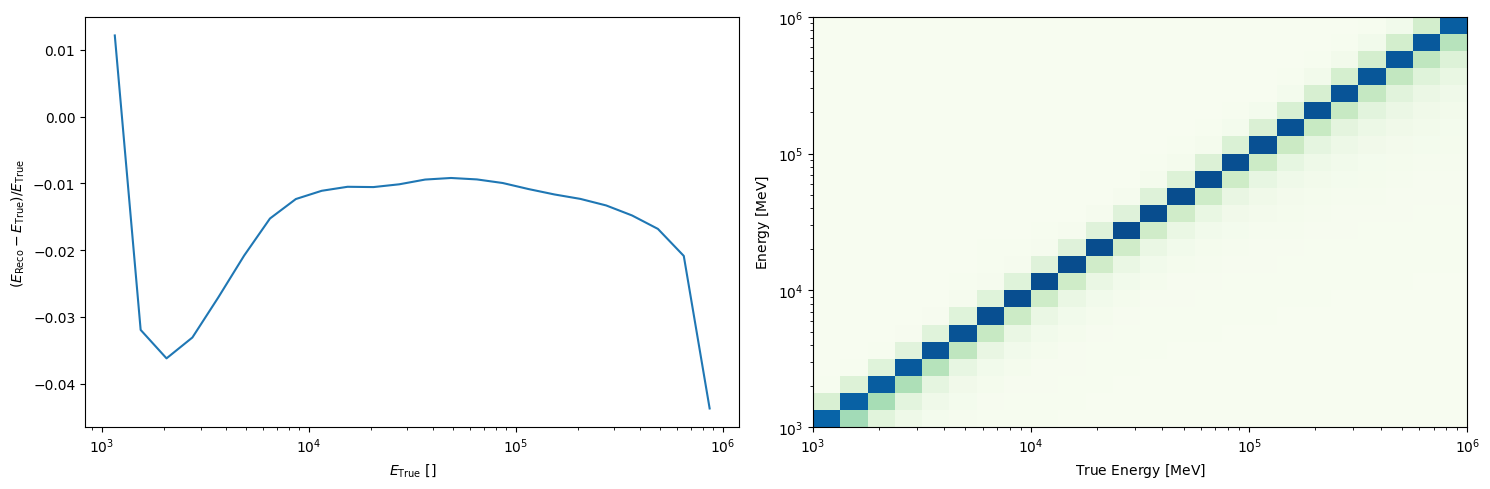

In [39]:
print(generate_3d_dataset.irfs["edisp_kernel"])
generate_3d_dataset.irfs["edisp_kernel"].peek()

In [40]:
%%time
generate_3d_dataset.load_events(file_list["events_file"])

CPU times: user 71.1 ms, sys: 26 ms, total: 97.1 ms
Wall time: 99.7 ms


### EventList and GTI

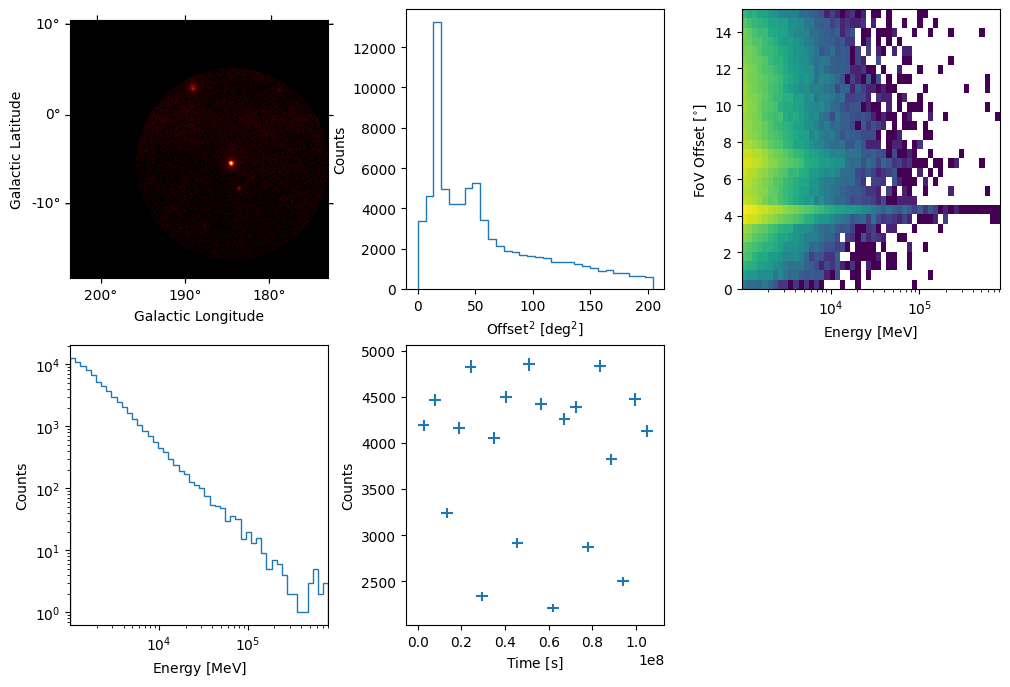

In [41]:
generate_3d_dataset.events["events"].peek()

In [42]:
print(generate_3d_dataset.events["gti"])

GTI info:
- Number of GTIs: 18978
- Duration: 90748484.2994926 s
- Start: 567993605.0 s MET
- Start: 2019-01-01T00:01:09.184 (time standard: TT)
- Stop: 675646997.0852783 s MET
- Stop: 2022-05-30T23:44:21.269 (time standard: TT)



In [43]:
%%time
# Source position from the Events file
center_pos = get_source_position(
    target_region=generate_3d_dataset.config_target,
    fits_header=generate_3d_dataset.events["event_fits"][1].header,
)
print(center_pos)

{'center': <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (83.633, 22.02)>, 'radius': 11.10660172}
CPU times: user 5.19 ms, sys: 2.14 ms, total: 7.32 ms
Wall time: 7.18 ms


## Create the Counts Map

In [44]:
%%time
generate_3d_dataset.events["counts_map"] = create_counts_map(
    geom_config=generate_3d_dataset.config_3d_dataset.dataset_info.geom,
    center_pos=center_pos,
)
generate_3d_dataset.events["counts_map"].fill_by_coord(
    {
        "skycoord": generate_3d_dataset.events["events"].radec,
        "energy": generate_3d_dataset.events["events"].energy,
        "time": generate_3d_dataset.events["events"].time,
    }
)

CPU times: user 2.39 s, sys: 71 ms, total: 2.46 s
Wall time: 2.46 s


In [45]:
generate_3d_dataset.events["counts_map"]

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (222, 222, 24)
	ndim  : 3
	unit  : 
	dtype : float64

In [46]:
generate_3d_dataset.events["counts_map"].plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

<WCSAxes: >

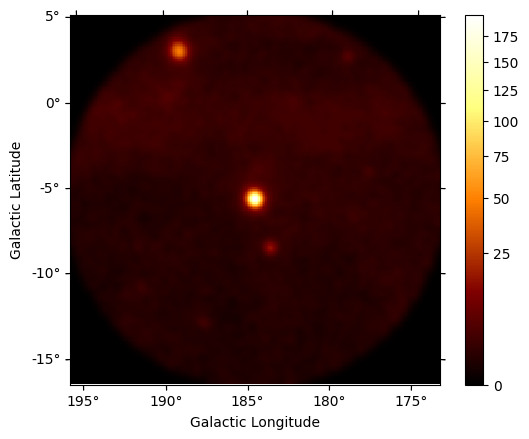

In [47]:
generate_3d_dataset.events["counts_map"].sum_over_axes().smooth(2).plot(stretch="sqrt", add_cbar=True)

### Exclusion mask

In [48]:
%%time
generate_3d_dataset.exclusion_mask = get_exclusion_region_mask(
    exclusion_params=generate_3d_dataset.config_3d_dataset.dataset_info.background.exclusion,
    excluded_geom=generate_3d_dataset.events["counts_map"].geom.copy(),
    exclusion_regions=exclusion_regions,
    config_target=generate_3d_dataset.config_target,
    geom_config=generate_3d_dataset.config_3d_dataset.dataset_info.geom,
    log=generate_3d_dataset.log,
)

CPU times: user 537 ms, sys: 111 ms, total: 648 ms
Wall time: 622 ms


In [49]:
print(generate_3d_dataset.exclusion_mask)

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (222, 222, 24)
	ndim  : 3
	unit  : 
	dtype : bool



In [50]:
generate_3d_dataset.exclusion_mask.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

### IRF interpolators

In [51]:
%%time
generate_3d_dataset.set_edisp_interpolator()

CPU times: user 6.32 ms, sys: 15.5 ms, total: 21.8 ms
Wall time: 6.33 ms


EDispKernel
-----------

  axes  : ['energy_true', 'energy']
  shape : (24, 24)
  ndim  : 2
  unit  : 
  dtype : float64



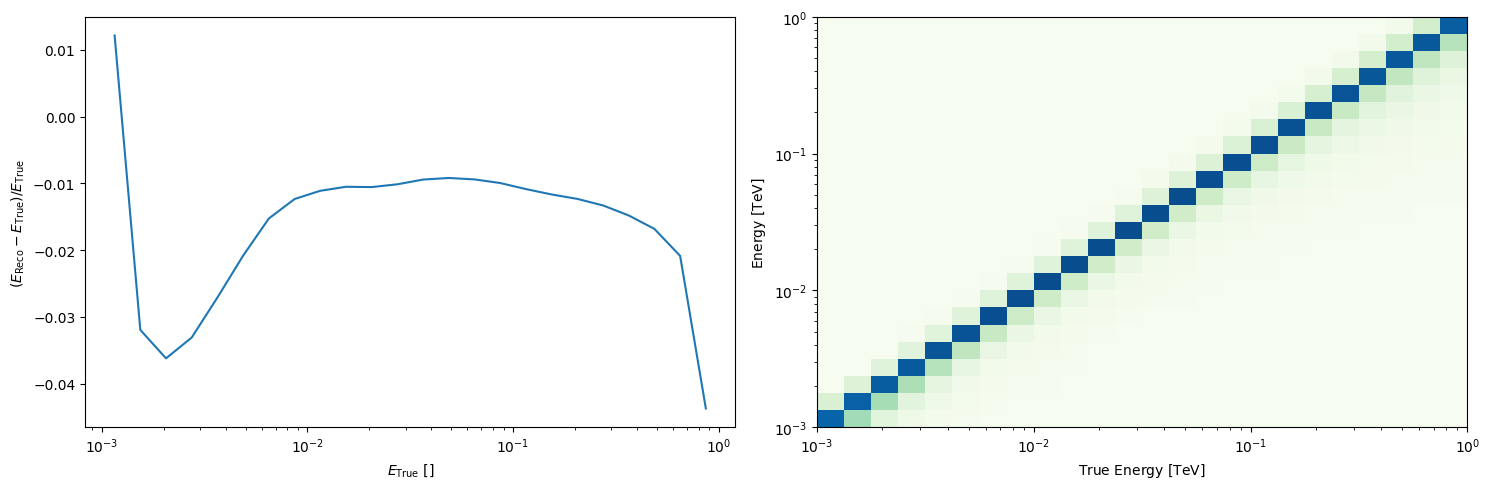

In [52]:
print(generate_3d_dataset.irfs["edisp_interp_kernel"])
generate_3d_dataset.irfs["edisp_interp_kernel"].peek()

In [53]:
%%time
generate_3d_dataset.set_exposure_interpolator()

CPU times: user 1 s, sys: 134 ms, total: 1.14 s
Wall time: 1.13 s


In [54]:
print(generate_3d_dataset.irfs["exposure_interp"])

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (222, 222, 24)
	ndim  : 3
	unit  : cm2 s
	dtype : float64



### Diffuse background cutout

In [55]:
%%time
generate_3d_dataset.generate_diffuse_background_cutout()

CPU times: user 37.4 ms, sys: 7.97 ms, total: 45.3 ms
Wall time: 43.2 ms


In [56]:
print(Models(generate_3d_dataset.list_source_models)["diffuse-iem"])

SkyModel

  Name                      : diffuse-iem
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




In [57]:
print(generate_3d_dataset.diffuse_models["gal_diffuse_cutout"])

SkyModel

  Name                      : diffuse-iem
  Datasets names            : None
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type       : 
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




# Apply Exclusion mask to models

In [58]:
generate_3d_dataset.list_source_models = apply_selection_mask_to_models(
    generate_3d_dataset.list_source_models,
    target_source=generate_3d_dataset.config_target.source_name,
    selection_mask=generate_3d_dataset.exclusion_mask,
)

In [59]:
for m in generate_3d_dataset.list_source_models:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.015       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.100   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         


Sky

### Produce MapDataset

In [60]:
%%time
dataset = generate_3d_dataset.generate_dataset(key_names[0])

Using the exclusion mask to create a safe mask


CPU times: user 9.26 ms, sys: 2.18 ms, total: 11.4 ms
Wall time: 10.2 ms


In [61]:
print(dataset)

MapDataset
----------

  Name                            : Fermi-LAT_00 

  Total counts                    : 23266 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : nan
  Predicted background counts     : nan
  Predicted excess counts         : nan

  Exposure min                    : 5.80e+10 cm2 s
  Exposure max                    : 7.19e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 186744 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [62]:
for m in generate_3d_dataset.list_source_models:
    print(m)

SkyModel

  Name                      : 4FGL J0534.5+2201i
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.00e-06   +/- 1.5e-07 1 / (TeV s cm2)
    reference             (frozen):      0.015       TeV         
    alpha                         :      1.700   +/-    0.10             
    beta                          :      0.100   +/-    0.00             
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.000                   
    lon_0                 (frozen):    184.553       deg         
    lat_0                 (frozen):     -5.781       deg         
    sigma                 (frozen):      0.020       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         


Sky

# Assigning models to the dataset

In [63]:
%%time
dataset.models = generate_3d_dataset.list_source_models

CPU times: user 3.86 ms, sys: 0 ns, total: 3.86 ms
Wall time: 3.77 ms


In [64]:
%%time
print(dataset)

/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/gammapy/utils/interpolation.py:185: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


MapDataset
----------

  Name                            : Fermi-LAT_00 

  Total counts                    : 23266 
  Total background counts         : nan
  Total excess counts             : nan

  Predicted counts                : 27152.35
  Predicted background counts     : nan
  Predicted excess counts         : 27152.35

  Exposure min                    : 5.80e+10 cm2 s
  Exposure max                    : 7.19e+10 cm2 s

  Number of total bins            : 1182816 
  Number of fit bins              : 186744 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 23284.30

  Number of models                : 10 
  Number of parameters            : 56
  Number of free parameters       : 22

  Component 0: SkyModel
  
    Name                      : 4FGL J0534.5+2201i
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
 

# Some basic plots from the Dataset

In [65]:
dataset.mask_safe.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

Text(0.5, 1.0, 'CountsMap')

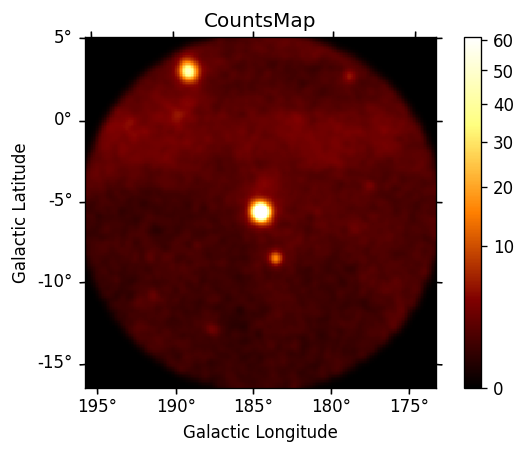

In [66]:
fig = plt.figure(figsize=(6, 3.8), dpi=120)
vmin, vmax = np.percentile(
    dataset.counts.sum_over_axes().smooth("0.1 deg").data, 
    [5, 99.9]
)
ax = dataset.counts.sum_over_axes().smooth("0.2 deg").plot(
    vmin=vmin, vmax=vmax, add_cbar=True, stretch="sqrt",
)
ax.set_title('CountsMap')

<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>

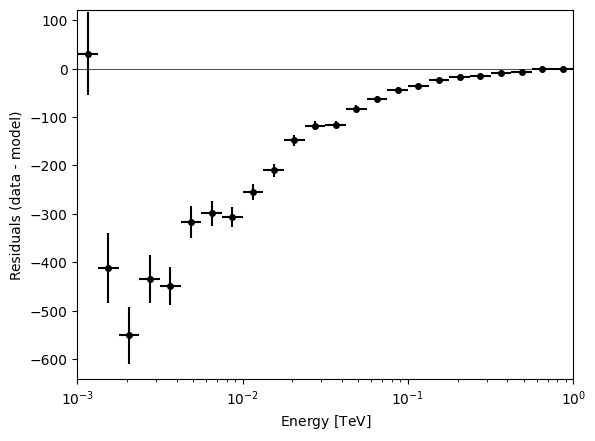

In [67]:
dataset.plot_residuals_spectral()

<WCSAxes: >

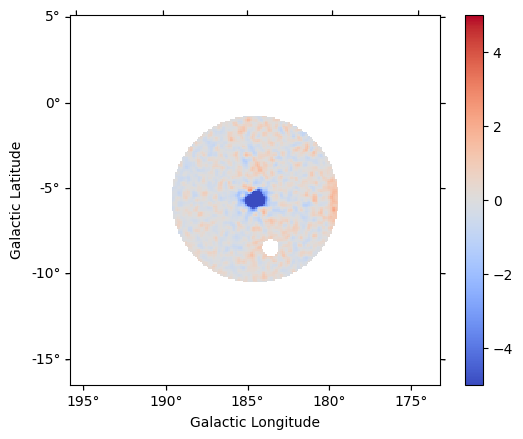

In [68]:
dataset.plot_residuals_spatial()

In [69]:
dataset.info_dict()

{'name': 'Fermi-LAT_00',
 'counts': 23266,
 'excess': nan,
 'sqrt_ts': nan,
 'background': nan,
 'npred': 27152.34706745111,
 'npred_background': nan,
 'npred_signal': 27152.34706745111,
 'exposure_min': <Quantity 5.79582612e+10 cm2 s>,
 'exposure_max': <Quantity 7.18732788e+10 cm2 s>,
 'livetime': <Quantity nan s>,
 'ontime': <Quantity 90748484.2994926 s>,
 'counts_rate': <Quantity nan 1 / s>,
 'background_rate': <Quantity nan 1 / s>,
 'excess_rate': <Quantity nan 1 / s>,
 'n_bins': 1182816,
 'n_fit_bins': 186744,
 'stat_type': 'cash',
 'stat_sum': 23284.297682062857}

/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/regions/shapes/ellipse.py:211: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/home/chaitanya.priyadarsh/anaconda3/envs/asgardpy/lib/python3.11/site-packages/regions/shapes/rectangle.py:208: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Rectangle(xy=xy, width=width, height=height,


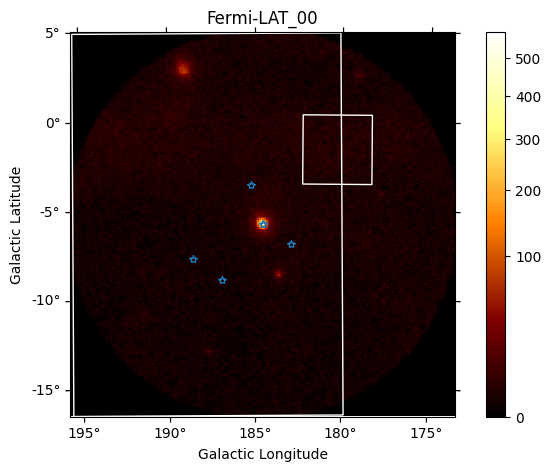

In [70]:
plt.figure(figsize=(8, 5))
axs = plt.subplot(111, projection=dataset.counts.geom.wcs)

dataset.counts.sum_over_axes().smooth(0.05 * u.deg).plot(
    ax=axs, stretch="sqrt", add_cbar=True, cmap="afmhot"
)
dataset.models.plot_regions(ax=axs, color="white")
axs.set_title(dataset.name)

plt.show()

In [71]:
dataset.exposure.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

<Axes: xlabel='True Energy [$\\mathrm{MeV}$]', ylabel='Containment radius [$\\mathrm{{}^{\\circ}}$]'>

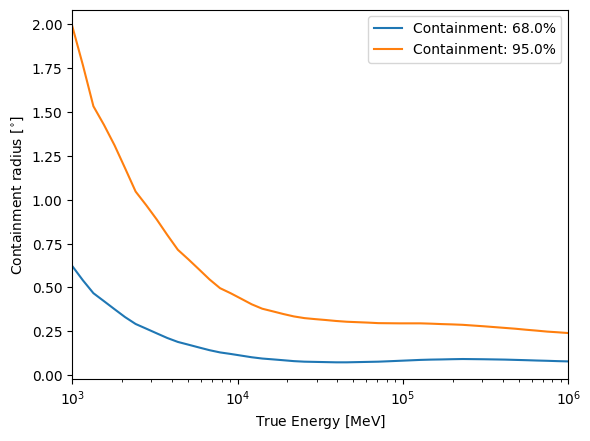

In [72]:
dataset.psf.plot_containment_radius_vs_energy()

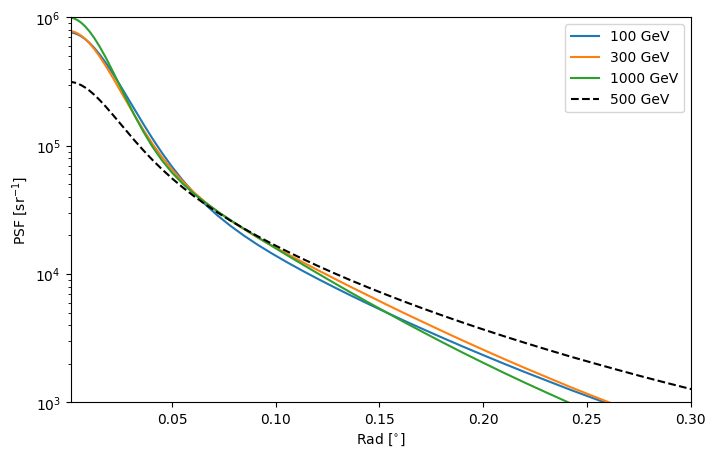

In [73]:
plt.figure(figsize=(8, 5))

energy = [100, 300, 1000] * u.GeV
dataset.psf.plot_psf_vs_rad(energy_true=energy)

spectrum = PowerLawSpectralModel(index=1.25)
psf_mean = dataset.psf.to_image(spectrum=spectrum)
psf_mean.plot_psf_vs_rad(c="k", ls="--", energy_true=[500] * u.GeV)

plt.xlim(1e-3, 0.3)
plt.ylim(1e3, 1e6)
plt.legend()

In [74]:
radius = dataset.psf.containment_radius(energy_true=1 * u.TeV, fraction=0.95)
print(radius)

[0.23928125] deg


<Axes: xlabel='True Energy [$\\mathrm{TeV}$]', ylabel='Energy [$\\mathrm{TeV}$]'>

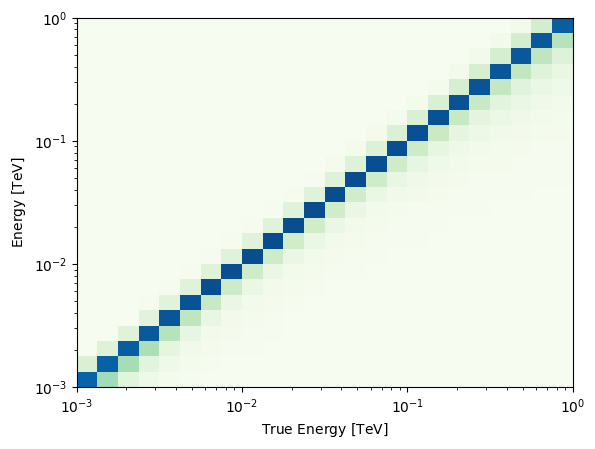

In [75]:
plt.figure()
edisp_kernel = dataset.edisp.get_edisp_kernel()
edisp_kernel.plot_matrix()

<WCSAxes: >

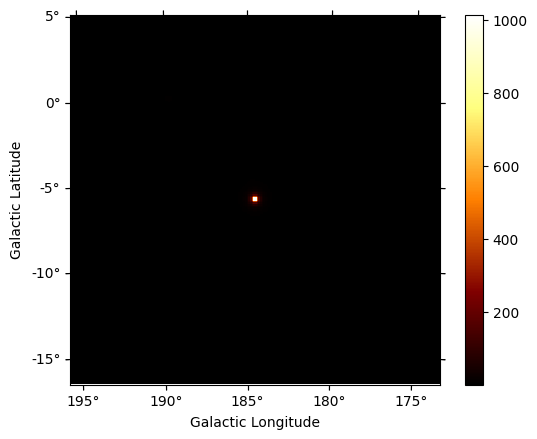

In [76]:
plt.figure()
npred = dataset.npred()
npred.sum_over_axes().plot(add_cbar=True)